In [1]:
from processed_image import ProcessedImage, read_from_dir, show_image_strip
imgs = list(read_from_dir('..\\Data\\LittleCarDb1'))
[str(img) for img in imgs[0:5]]

['ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-001_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-002_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-005_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-007_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-008_1.jpg (0 in cache)']

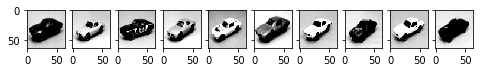

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 10, sharey=True, figsize=(8,1.5))
show_image_strip(imgs, axes)

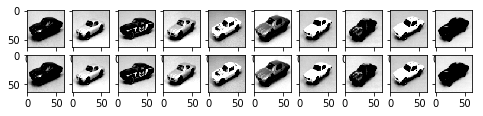

In [3]:
_, axes = plt.subplots(2, 10, sharey=True, figsize=(8,1.5))
processed_dict = {img.fullpath:img.get_processed_image() for img in imgs}
show_image_strip(imgs, axes, predicted_dict=processed_dict)

In [4]:
import numpy as np
x_train = [img.get_processed_image(size=128) for img in imgs]
x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))

In [5]:
from model_vae_3stage import ModelVae3Stage
all_model = ModelVae3Stage(size=128, in_channels=1, latent_dim=8)
vae, enc, dec = all_model.vae, all_model.encoder, all_model.decoder

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [6]:
import random
x_test = np.array(random.sample(list(x_train), int(len(x_train)/10)))
x_train.shape, x_test.shape

((171, 128, 128, 1), (17, 128, 128, 1))

In [7]:
vae.fit(x_train, x_train, epochs=1000, batch_size=1024, 
        shuffle=True, validation_data=(x_test,x_test))

Instructions for updating:
Use tf.cast instead.
Train on 171 samples, validate on 17 samples
Epoch 1/1000
171/171 [==============================] - 15s 90ms/step - loss: 11355.4434 - val_loss: 11284.0977
Epoch 2/1000
171/171 [==============================] - 0s 2ms/step - loss: 11273.7178 - val_loss: 11008.8057
Epoch 3/1000
171/171 [==============================] - 0s 2ms/step - loss: 10954.2344 - val_loss: 13034.4121
Epoch 4/1000
171/171 [==============================] - 0s 1ms/step - loss: 12323.9209 - val_loss: 11040.9297
Epoch 5/1000
171/171 [==============================] - 0s 1ms/step - loss: 11011.8965 - val_loss: 10727.7129
Epoch 6/1000
171/171 [==============================] - 0s 1ms/step - loss: 10645.1680 - val_loss: 10492.5684
Epoch 7/1000
171/171 [==============================] - 0s 1ms/step - loss: 10371.0977 - val_loss: 10342.5703
Epoch 8/1000
171/171 [==============================] - 0s 1ms/step - loss: 10256.6094 - val_loss: 9885.4463
Epoch 9/1000
171/171 [====

171/171 [==============================] - 0s 2ms/step - loss: 8855.7949 - val_loss: 8675.0225
Epoch 74/1000
171/171 [==============================] - 0s 2ms/step - loss: 8359.4023 - val_loss: 8702.2412
Epoch 75/1000
171/171 [==============================] - 0s 1ms/step - loss: 8362.6445 - val_loss: 8993.1855
Epoch 76/1000
171/171 [==============================] - 0s 2ms/step - loss: 8668.8672 - val_loss: 8586.5234
Epoch 77/1000
171/171 [==============================] - 0s 2ms/step - loss: 8241.6318 - val_loss: 8743.0527
Epoch 78/1000
171/171 [==============================] - 0s 1ms/step - loss: 8324.2295 - val_loss: 8533.3203
Epoch 79/1000
171/171 [==============================] - 0s 2ms/step - loss: 8316.6182 - val_loss: 9006.8701
Epoch 80/1000
171/171 [==============================] - 0s 2ms/step - loss: 8631.1553 - val_loss: 8577.1855
Epoch 81/1000
171/171 [==============================] - 0s 1ms/step - loss: 8238.4648 - val_loss: 8669.4258
Epoch 82/1000
171/171 [==========

Epoch 148/1000
171/171 [==============================] - 0s 2ms/step - loss: 7915.5835 - val_loss: 8343.4590
Epoch 149/1000
171/171 [==============================] - 0s 2ms/step - loss: 8100.8071 - val_loss: 8157.2075
Epoch 150/1000
171/171 [==============================] - 0s 1ms/step - loss: 7868.3135 - val_loss: 8398.8496
Epoch 151/1000
171/171 [==============================] - 0s 2ms/step - loss: 8065.6104 - val_loss: 8111.4883
Epoch 152/1000
171/171 [==============================] - 0s 2ms/step - loss: 7871.7134 - val_loss: 8421.1445
Epoch 153/1000
171/171 [==============================] - 0s 2ms/step - loss: 8076.0015 - val_loss: 8052.9043
Epoch 154/1000
171/171 [==============================] - 0s 2ms/step - loss: 7826.2646 - val_loss: 8241.9307
Epoch 155/1000
171/171 [==============================] - 0s 2ms/step - loss: 7970.4165 - val_loss: 8301.8252
Epoch 156/1000
171/171 [==============================] - 0s 2ms/step - loss: 7977.5674 - val_loss: 8381.9482
Epoch 157/

Epoch 223/1000
171/171 [==============================] - 0s 2ms/step - loss: 7678.7485 - val_loss: 7995.4043
Epoch 224/1000
171/171 [==============================] - 0s 2ms/step - loss: 7776.4087 - val_loss: 7880.0874
Epoch 225/1000
171/171 [==============================] - 0s 2ms/step - loss: 7675.7368 - val_loss: 7996.2832
Epoch 226/1000
171/171 [==============================] - 0s 2ms/step - loss: 7798.1548 - val_loss: 7790.0781
Epoch 227/1000
171/171 [==============================] - 0s 1ms/step - loss: 7599.8525 - val_loss: 7863.6772
Epoch 228/1000
171/171 [==============================] - 0s 2ms/step - loss: 7659.9570 - val_loss: 7739.6855
Epoch 229/1000
171/171 [==============================] - 0s 1ms/step - loss: 7560.3887 - val_loss: 7936.0459
Epoch 230/1000
171/171 [==============================] - 0s 1ms/step - loss: 7714.4854 - val_loss: 7746.7988
Epoch 231/1000
171/171 [==============================] - 0s 2ms/step - loss: 7598.2827 - val_loss: 8002.6426
Epoch 232/

Epoch 298/1000
171/171 [==============================] - 0s 2ms/step - loss: 7387.0576 - val_loss: 7678.8315
Epoch 299/1000
171/171 [==============================] - 0s 2ms/step - loss: 7465.1279 - val_loss: 7638.0972
Epoch 300/1000
171/171 [==============================] - 0s 2ms/step - loss: 7476.7041 - val_loss: 7868.1367
Epoch 301/1000
171/171 [==============================] - 0s 2ms/step - loss: 7607.0278 - val_loss: 7534.5830
Epoch 302/1000
171/171 [==============================] - 0s 1ms/step - loss: 7375.6069 - val_loss: 7574.5376
Epoch 303/1000
171/171 [==============================] - 0s 2ms/step - loss: 7374.0312 - val_loss: 7537.4902
Epoch 304/1000
171/171 [==============================] - 0s 2ms/step - loss: 7376.1128 - val_loss: 7754.8384
Epoch 305/1000
171/171 [==============================] - 0s 2ms/step - loss: 7582.3647 - val_loss: 7784.7437
Epoch 306/1000
171/171 [==============================] - 0s 2ms/step - loss: 7492.7881 - val_loss: 7655.5220
Epoch 307/

Epoch 373/1000
171/171 [==============================] - 0s 2ms/step - loss: 7304.2275 - val_loss: 7490.0605
Epoch 374/1000
171/171 [==============================] - 0s 1ms/step - loss: 7276.7974 - val_loss: 7482.6880
Epoch 375/1000
171/171 [==============================] - 0s 2ms/step - loss: 7292.6558 - val_loss: 7592.2295
Epoch 376/1000
171/171 [==============================] - 0s 2ms/step - loss: 7347.8267 - val_loss: 7486.3633
Epoch 377/1000
171/171 [==============================] - 0s 2ms/step - loss: 7308.7104 - val_loss: 7721.0894
Epoch 378/1000
171/171 [==============================] - 0s 2ms/step - loss: 7431.7280 - val_loss: 7403.4795
Epoch 379/1000
171/171 [==============================] - 0s 2ms/step - loss: 7239.9438 - val_loss: 7548.1167
Epoch 380/1000
171/171 [==============================] - 0s 2ms/step - loss: 7295.2056 - val_loss: 7347.7793
Epoch 381/1000
171/171 [==============================] - 0s 2ms/step - loss: 7190.2056 - val_loss: 7553.0073
Epoch 382/

Epoch 448/1000
171/171 [==============================] - 0s 2ms/step - loss: 7258.6055 - val_loss: 7296.0439
Epoch 449/1000
171/171 [==============================] - 0s 2ms/step - loss: 7069.8984 - val_loss: 7323.0146
Epoch 450/1000
171/171 [==============================] - 0s 2ms/step - loss: 7131.1724 - val_loss: 7246.4053
Epoch 451/1000
171/171 [==============================] - 0s 2ms/step - loss: 7033.2998 - val_loss: 7328.3916
Epoch 452/1000
171/171 [==============================] - 0s 1ms/step - loss: 7133.4805 - val_loss: 7239.6836
Epoch 453/1000
171/171 [==============================] - 0s 2ms/step - loss: 7054.1294 - val_loss: 7377.9600
Epoch 454/1000
171/171 [==============================] - 0s 2ms/step - loss: 7186.7017 - val_loss: 7283.5352
Epoch 455/1000
171/171 [==============================] - 0s 2ms/step - loss: 7074.5234 - val_loss: 7282.2085
Epoch 456/1000
171/171 [==============================] - 0s 2ms/step - loss: 7088.7485 - val_loss: 7311.0195
Epoch 457/

Epoch 523/1000
171/171 [==============================] - 0s 2ms/step - loss: 7004.6440 - val_loss: 7420.3589
Epoch 524/1000
171/171 [==============================] - 0s 2ms/step - loss: 7161.8813 - val_loss: 7237.8335
Epoch 525/1000
171/171 [==============================] - 0s 2ms/step - loss: 7043.1943 - val_loss: 7291.6396
Epoch 526/1000
171/171 [==============================] - 0s 2ms/step - loss: 7042.0869 - val_loss: 7244.9287
Epoch 527/1000
171/171 [==============================] - 0s 2ms/step - loss: 7072.6396 - val_loss: 7308.2842
Epoch 528/1000
171/171 [==============================] - 0s 2ms/step - loss: 7036.8369 - val_loss: 7230.9419
Epoch 529/1000
171/171 [==============================] - 0s 2ms/step - loss: 7043.9546 - val_loss: 7500.7368
Epoch 530/1000
171/171 [==============================] - 0s 2ms/step - loss: 7183.2324 - val_loss: 7160.0210
Epoch 531/1000
171/171 [==============================] - 0s 2ms/step - loss: 6983.1416 - val_loss: 7302.1240
Epoch 532/

Epoch 598/1000
171/171 [==============================] - 0s 2ms/step - loss: 6871.3071 - val_loss: 6998.1509
Epoch 599/1000
171/171 [==============================] - 0s 2ms/step - loss: 6808.1294 - val_loss: 7076.0459
Epoch 600/1000
171/171 [==============================] - 0s 2ms/step - loss: 6867.3340 - val_loss: 6993.7148
Epoch 601/1000
171/171 [==============================] - 0s 2ms/step - loss: 6821.9634 - val_loss: 7148.3896
Epoch 602/1000
171/171 [==============================] - 0s 2ms/step - loss: 6924.4502 - val_loss: 7044.5156
Epoch 603/1000
171/171 [==============================] - 0s 2ms/step - loss: 6872.9150 - val_loss: 7254.4756
Epoch 604/1000
171/171 [==============================] - 0s 2ms/step - loss: 7007.7090 - val_loss: 7221.6284
Epoch 605/1000
171/171 [==============================] - 0s 2ms/step - loss: 7033.1426 - val_loss: 7286.0166
Epoch 606/1000
171/171 [==============================] - 0s 2ms/step - loss: 7007.1650 - val_loss: 7130.9224
Epoch 607/

Epoch 673/1000
171/171 [==============================] - 0s 1ms/step - loss: 6833.9780 - val_loss: 7101.3892
Epoch 674/1000
171/171 [==============================] - 0s 1ms/step - loss: 6850.4971 - val_loss: 7032.2891
Epoch 675/1000
171/171 [==============================] - 0s 2ms/step - loss: 6846.3159 - val_loss: 7091.0801
Epoch 676/1000
171/171 [==============================] - 0s 2ms/step - loss: 6823.4702 - val_loss: 7010.5742
Epoch 677/1000
171/171 [==============================] - 0s 1ms/step - loss: 6780.5278 - val_loss: 7028.4937
Epoch 678/1000
171/171 [==============================] - 0s 1ms/step - loss: 6803.6055 - val_loss: 6906.9014
Epoch 679/1000
171/171 [==============================] - 0s 1ms/step - loss: 6718.3291 - val_loss: 6934.9707
Epoch 680/1000
171/171 [==============================] - 0s 2ms/step - loss: 6734.7158 - val_loss: 6879.1118
Epoch 681/1000
171/171 [==============================] - 0s 2ms/step - loss: 6690.1279 - val_loss: 6909.9214
Epoch 682/

Epoch 748/1000
171/171 [==============================] - 0s 2ms/step - loss: 6801.6250 - val_loss: 6951.2148
Epoch 749/1000
171/171 [==============================] - 0s 2ms/step - loss: 6790.2017 - val_loss: 7140.8179
Epoch 750/1000
171/171 [==============================] - 0s 2ms/step - loss: 6878.8828 - val_loss: 6874.4678
Epoch 751/1000
171/171 [==============================] - 0s 2ms/step - loss: 6705.0146 - val_loss: 6929.0728
Epoch 752/1000
171/171 [==============================] - 0s 2ms/step - loss: 6712.2251 - val_loss: 6828.5415
Epoch 753/1000
171/171 [==============================] - 0s 2ms/step - loss: 6652.0483 - val_loss: 6877.2612
Epoch 754/1000
171/171 [==============================] - 0s 2ms/step - loss: 6672.9805 - val_loss: 6823.1274
Epoch 755/1000
171/171 [==============================] - 0s 2ms/step - loss: 6645.9722 - val_loss: 6876.5527
Epoch 756/1000
171/171 [==============================] - 0s 2ms/step - loss: 6664.3735 - val_loss: 6875.9556
Epoch 757/

Epoch 823/1000
171/171 [==============================] - 0s 1ms/step - loss: 6807.4854 - val_loss: 6839.9297
Epoch 824/1000
171/171 [==============================] - 0s 1ms/step - loss: 6654.3540 - val_loss: 6886.6597
Epoch 825/1000
171/171 [==============================] - 0s 2ms/step - loss: 6675.4482 - val_loss: 6827.8779
Epoch 826/1000
171/171 [==============================] - 0s 1ms/step - loss: 6650.6187 - val_loss: 6875.3018
Epoch 827/1000
171/171 [==============================] - 0s 1ms/step - loss: 6678.6084 - val_loss: 6877.4062
Epoch 828/1000
171/171 [==============================] - 0s 2ms/step - loss: 6689.5029 - val_loss: 6860.6812
Epoch 829/1000
171/171 [==============================] - 0s 2ms/step - loss: 6668.4692 - val_loss: 6843.5923
Epoch 830/1000
171/171 [==============================] - 0s 2ms/step - loss: 6657.8721 - val_loss: 6831.3916
Epoch 831/1000
171/171 [==============================] - 0s 1ms/step - loss: 6640.2725 - val_loss: 6802.5479
Epoch 832/

Epoch 898/1000
171/171 [==============================] - 0s 2ms/step - loss: 6582.7798 - val_loss: 6778.2510
Epoch 899/1000
171/171 [==============================] - 0s 2ms/step - loss: 6605.9736 - val_loss: 6769.1289
Epoch 900/1000
171/171 [==============================] - 0s 2ms/step - loss: 6591.0576 - val_loss: 6814.6377
Epoch 901/1000
171/171 [==============================] - 0s 2ms/step - loss: 6637.3530 - val_loss: 6744.3027
Epoch 902/1000
171/171 [==============================] - 0s 2ms/step - loss: 6569.2026 - val_loss: 6788.8320
Epoch 903/1000
171/171 [==============================] - 0s 2ms/step - loss: 6602.6445 - val_loss: 6720.2817
Epoch 904/1000
171/171 [==============================] - 0s 2ms/step - loss: 6546.8960 - val_loss: 6757.9258
Epoch 905/1000
171/171 [==============================] - 0s 2ms/step - loss: 6574.0498 - val_loss: 6700.0762
Epoch 906/1000
171/171 [==============================] - 0s 2ms/step - loss: 6534.3208 - val_loss: 6738.9263
Epoch 907/

Epoch 973/1000
171/171 [==============================] - 0s 2ms/step - loss: 6512.8042 - val_loss: 6704.3320
Epoch 974/1000
171/171 [==============================] - 0s 2ms/step - loss: 6545.1382 - val_loss: 6666.2642
Epoch 975/1000
171/171 [==============================] - 0s 2ms/step - loss: 6497.8115 - val_loss: 6719.8081
Epoch 976/1000
171/171 [==============================] - 0s 2ms/step - loss: 6563.4995 - val_loss: 6674.2466
Epoch 977/1000
171/171 [==============================] - 0s 2ms/step - loss: 6507.8779 - val_loss: 6752.4731
Epoch 978/1000
171/171 [==============================] - 0s 2ms/step - loss: 6589.4922 - val_loss: 6678.4209
Epoch 979/1000
171/171 [==============================] - 0s 2ms/step - loss: 6514.2485 - val_loss: 6755.1694
Epoch 980/1000
171/171 [==============================] - 0s 2ms/step - loss: 6590.9692 - val_loss: 6691.2412
Epoch 981/1000
171/171 [==============================] - 0s 2ms/step - loss: 6520.1230 - val_loss: 6754.9102
Epoch 982/

In [8]:
def show_original_decoded(original, decoded, sz):
    n = 10  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(original[i].reshape(128, 128), cmap='gray')
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(decoded[i].reshape(128, 128), cmap='gray')
    plt.show()

(17, 128, 128, 1) -> (17, 8) -> (17, 128, 128, 1)


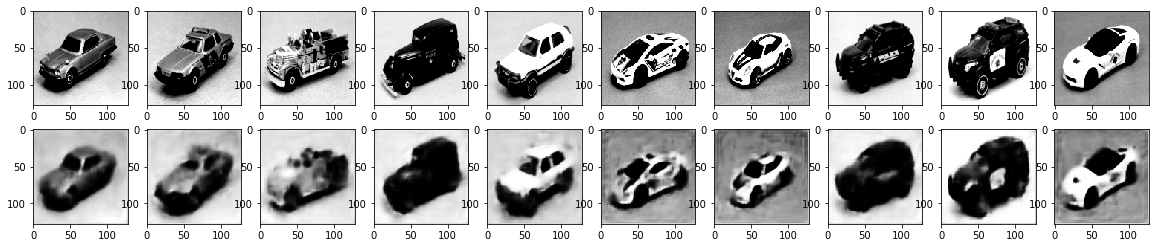

In [9]:
encoded_latent = enc.predict(x_test)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(x_test.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)
show_original_decoded(x_test, decoded_imgs, 128)

In [ ]:
vae.fit(x_train, x_train, epochs=1000, batch_size=1024, 
        shuffle=True, validation_data=(x_test,x_test))

Train on 171 samples, validate on 17 samples
Epoch 1/1000
171/171 [==============================] - 0s 2ms/step - loss: 6585.9429 - val_loss: 6734.1914
Epoch 2/1000
171/171 [==============================] - 0s 2ms/step - loss: 6574.0776 - val_loss: 6725.2681
Epoch 3/1000
171/171 [==============================] - 0s 2ms/step - loss: 6574.2998 - val_loss: 6757.5552
Epoch 4/1000
171/171 [==============================] - 0s 2ms/step - loss: 6582.5586 - val_loss: 6736.5347
Epoch 5/1000
171/171 [==============================] - 0s 2ms/step - loss: 6589.2896 - val_loss: 6816.2930
Epoch 6/1000
171/171 [==============================] - 0s 2ms/step - loss: 6624.0059 - val_loss: 6722.4473
Epoch 7/1000
171/171 [==============================] - 0s 2ms/step - loss: 6558.0249 - val_loss: 6746.4492
Epoch 8/1000
171/171 [==============================] - 0s 1ms/step - loss: 6564.0220 - val_loss: 6682.1323
Epoch 9/1000
171/171 [==============================] - 0s 1ms/step - loss: 6520.8721 - val

Epoch 76/1000
171/171 [==============================] - 0s 1ms/step - loss: 6599.7280 - val_loss: 6783.2578
Epoch 77/1000
171/171 [==============================] - 0s 2ms/step - loss: 6602.3735 - val_loss: 6756.0142
Epoch 78/1000
171/171 [==============================] - 0s 1ms/step - loss: 6612.7148 - val_loss: 6764.4492
Epoch 79/1000
171/171 [==============================] - 0s 1ms/step - loss: 6576.0063 - val_loss: 6681.6094
Epoch 80/1000
171/171 [==============================] - 0s 1ms/step - loss: 6533.1250 - val_loss: 6734.9966
Epoch 81/1000
171/171 [==============================] - 0s 1ms/step - loss: 6548.0078 - val_loss: 6686.4365
Epoch 82/1000
171/171 [==============================] - 0s 2ms/step - loss: 6530.3628 - val_loss: 6743.0903
Epoch 83/1000
171/171 [==============================] - 0s 1ms/step - loss: 6548.0557 - val_loss: 6684.0430
Epoch 84/1000
171/171 [==============================] - 0s 1ms/step - loss: 6530.4312 - val_loss: 6698.5107
Epoch 85/1000
171/1

Epoch 151/1000
171/171 [==============================] - 0s 2ms/step - loss: 6477.4194 - val_loss: 6661.9121
Epoch 152/1000
171/171 [==============================] - 0s 2ms/step - loss: 6524.9722 - val_loss: 6655.6338
Epoch 153/1000
171/171 [==============================] - 0s 1ms/step - loss: 6504.5605 - val_loss: 6681.3931
Epoch 154/1000
171/171 [==============================] - 0s 2ms/step - loss: 6537.5791 - val_loss: 6727.4429
Epoch 155/1000
171/171 [==============================] - 0s 2ms/step - loss: 6548.2031 - val_loss: 6781.6367
Epoch 156/1000
171/171 [==============================] - 0s 2ms/step - loss: 6601.9160 - val_loss: 6752.2627
Epoch 157/1000
171/171 [==============================] - 0s 2ms/step - loss: 6606.6885 - val_loss: 6829.0483
Epoch 158/1000
171/171 [==============================] - 0s 2ms/step - loss: 6656.5894 - val_loss: 6882.0806
Epoch 159/1000
171/171 [==============================] - 0s 2ms/step - loss: 6660.3062 - val_loss: 7017.9023
Epoch 160/

Epoch 226/1000
171/171 [==============================] - 0s 2ms/step - loss: 6442.1885 - val_loss: 6589.8672
Epoch 227/1000
171/171 [==============================] - 0s 2ms/step - loss: 6448.6982 - val_loss: 6614.8169
Epoch 228/1000
171/171 [==============================] - 0s 2ms/step - loss: 6466.4878 - val_loss: 6620.9849
Epoch 229/1000
171/171 [==============================] - 0s 2ms/step - loss: 6480.4131 - val_loss: 6618.2705
Epoch 230/1000
171/171 [==============================] - 0s 2ms/step - loss: 6467.0410 - val_loss: 6610.2104
Epoch 231/1000
171/171 [==============================] - 0s 2ms/step - loss: 6465.6616 - val_loss: 6592.7773
Epoch 232/1000
171/171 [==============================] - 0s 2ms/step - loss: 6443.3896 - val_loss: 6578.3032
Epoch 233/1000
171/171 [==============================] - 0s 2ms/step - loss: 6439.5474 - val_loss: 6576.9551
Epoch 234/1000
171/171 [==============================] - 0s 2ms/step - loss: 6435.1353 - val_loss: 6576.3237
Epoch 235/

Epoch 301/1000
171/171 [==============================] - 0s 2ms/step - loss: 6412.8555 - val_loss: 6564.0381
Epoch 302/1000
171/171 [==============================] - 0s 2ms/step - loss: 6422.9175 - val_loss: 6538.5376
Epoch 303/1000
171/171 [==============================] - 0s 2ms/step - loss: 6405.3853 - val_loss: 6563.3564
Epoch 304/1000
171/171 [==============================] - 0s 2ms/step - loss: 6432.0547 - val_loss: 6535.3325
Epoch 305/1000
171/171 [==============================] - 0s 2ms/step - loss: 6406.8628 - val_loss: 6576.3813
Epoch 306/1000
171/171 [==============================] - 0s 2ms/step - loss: 6441.6719 - val_loss: 6536.5034
Epoch 307/1000
171/171 [==============================] - 0s 2ms/step - loss: 6405.9839 - val_loss: 6560.3574
Epoch 308/1000
171/171 [==============================] - 0s 2ms/step - loss: 6427.3647 - val_loss: 6552.7422
Epoch 309/1000
171/171 [==============================] - 0s 2ms/step - loss: 6413.9570 - val_loss: 6566.7490
Epoch 310/

Epoch 376/1000
171/171 [==============================] - 0s 2ms/step - loss: 6399.5425 - val_loss: 6580.5215
Epoch 377/1000
171/171 [==============================] - 0s 2ms/step - loss: 6417.8057 - val_loss: 6549.0083
Epoch 378/1000
171/171 [==============================] - 0s 2ms/step - loss: 6406.7661 - val_loss: 6594.5586
Epoch 379/1000
171/171 [==============================] - 0s 2ms/step - loss: 6438.5796 - val_loss: 6536.3623
Epoch 380/1000
171/171 [==============================] - 0s 2ms/step - loss: 6409.3721 - val_loss: 6590.8032
Epoch 381/1000
171/171 [==============================] - 0s 2ms/step - loss: 6436.8193 - val_loss: 6512.7690
Epoch 382/1000
171/171 [==============================] - 0s 2ms/step - loss: 6389.4321 - val_loss: 6560.4487
Epoch 383/1000
171/171 [==============================] - 0s 2ms/step - loss: 6423.1782 - val_loss: 6508.5435
Epoch 384/1000
171/171 [==============================] - 0s 2ms/step - loss: 6388.8794 - val_loss: 6607.3130
Epoch 385/

Epoch 451/1000
171/171 [==============================] - 0s 2ms/step - loss: 6448.6738 - val_loss: 6534.1079
Epoch 452/1000
171/171 [==============================] - 0s 2ms/step - loss: 6426.0923 - val_loss: 6562.3379
Epoch 453/1000
171/171 [==============================] - 0s 2ms/step - loss: 6417.9575 - val_loss: 6517.3457
Epoch 454/1000
171/171 [==============================] - 0s 2ms/step - loss: 6402.3174 - val_loss: 6528.1899
Epoch 455/1000
171/171 [==============================] - 0s 2ms/step - loss: 6391.1621 - val_loss: 6522.1812
Epoch 456/1000
171/171 [==============================] - 0s 2ms/step - loss: 6394.2632 - val_loss: 6530.1948
Epoch 457/1000
171/171 [==============================] - 0s 2ms/step - loss: 6388.7407 - val_loss: 6532.6880
Epoch 458/1000
171/171 [==============================] - 0s 2ms/step - loss: 6401.5483 - val_loss: 6527.3135
Epoch 459/1000
171/171 [==============================] - 0s 2ms/step - loss: 6383.7310 - val_loss: 6528.7017
Epoch 460/

Epoch 526/1000
171/171 [==============================] - 0s 2ms/step - loss: 6380.7544 - val_loss: 6524.2500
Epoch 527/1000
171/171 [==============================] - 0s 1ms/step - loss: 6382.7749 - val_loss: 6540.5840
Epoch 528/1000
171/171 [==============================] - 0s 1ms/step - loss: 6404.2515 - val_loss: 6526.1782
Epoch 529/1000
171/171 [==============================] - 0s 1ms/step - loss: 6376.9707 - val_loss: 6536.8481
Epoch 530/1000
171/171 [==============================] - 0s 2ms/step - loss: 6392.7192 - val_loss: 6503.5474
Epoch 531/1000
171/171 [==============================] - 0s 2ms/step - loss: 6368.8931 - val_loss: 6508.3691
Epoch 532/1000
171/171 [==============================] - 0s 2ms/step - loss: 6378.4824 - val_loss: 6507.5059
Epoch 533/1000
171/171 [==============================] - 0s 2ms/step - loss: 6377.4629 - val_loss: 6511.9497
Epoch 534/1000
171/171 [==============================] - 0s 2ms/step - loss: 6378.7852 - val_loss: 6523.2563
Epoch 535/

Epoch 601/1000
171/171 [==============================] - 0s 2ms/step - loss: 6395.1533 - val_loss: 6493.7769
Epoch 602/1000
171/171 [==============================] - 0s 2ms/step - loss: 6370.0107 - val_loss: 6521.2021
Epoch 603/1000
171/171 [==============================] - 0s 2ms/step - loss: 6393.1724 - val_loss: 6510.8994
Epoch 604/1000
171/171 [==============================] - 0s 2ms/step - loss: 6390.8149 - val_loss: 6522.2954
Epoch 605/1000
171/171 [==============================] - 0s 2ms/step - loss: 6390.5430 - val_loss: 6504.4009
Epoch 606/1000
171/171 [==============================] - 0s 2ms/step - loss: 6385.8428 - val_loss: 6498.2866
Epoch 607/1000
171/171 [==============================] - 0s 2ms/step - loss: 6372.8115 - val_loss: 6512.6636
Epoch 608/1000
171/171 [==============================] - 0s 1ms/step - loss: 6378.4180 - val_loss: 6514.2559
Epoch 609/1000
171/171 [==============================] - 0s 1ms/step - loss: 6388.5020 - val_loss: 6530.8203
Epoch 610/

Epoch 676/1000
171/171 [==============================] - 0s 1ms/step - loss: 6381.4912 - val_loss: 6493.5356
Epoch 677/1000
171/171 [==============================] - 0s 2ms/step - loss: 6377.5483 - val_loss: 6534.9331
Epoch 678/1000
171/171 [==============================] - 0s 2ms/step - loss: 6389.7559 - val_loss: 6494.5918
Epoch 679/1000
171/171 [==============================] - 0s 2ms/step - loss: 6374.4077 - val_loss: 6526.9302
Epoch 680/1000
171/171 [==============================] - 0s 2ms/step - loss: 6385.5981 - val_loss: 6477.8589
Epoch 681/1000
171/171 [==============================] - 0s 2ms/step - loss: 6356.3306 - val_loss: 6490.8623
Epoch 682/1000
171/171 [==============================] - 0s 1ms/step - loss: 6358.4453 - val_loss: 6461.0029
Epoch 683/1000
171/171 [==============================] - 0s 1ms/step - loss: 6341.0132 - val_loss: 6472.9575
Epoch 684/1000
171/171 [==============================] - 0s 2ms/step - loss: 6341.9321 - val_loss: 6460.1782
Epoch 685/

Epoch 751/1000
171/171 [==============================] - 0s 2ms/step - loss: 6324.8516 - val_loss: 6478.1167
Epoch 752/1000
171/171 [==============================] - 0s 1ms/step - loss: 6359.1143 - val_loss: 6440.8379
Epoch 753/1000
171/171 [==============================] - 0s 1ms/step - loss: 6319.8384 - val_loss: 6466.7490
Epoch 754/1000
171/171 [==============================] - 0s 1ms/step - loss: 6347.4102 - val_loss: 6428.7271
Epoch 755/1000
171/171 [==============================] - 0s 2ms/step - loss: 6312.6279 - val_loss: 6460.0288
Epoch 756/1000
171/171 [==============================] - 0s 1ms/step - loss: 6341.6270 - val_loss: 6433.5503
Epoch 757/1000
171/171 [==============================] - 0s 2ms/step - loss: 6317.2178 - val_loss: 6478.2480
Epoch 758/1000
171/171 [==============================] - 0s 1ms/step - loss: 6354.7793 - val_loss: 6449.1367
Epoch 759/1000
171/171 [==============================] - 0s 2ms/step - loss: 6326.6372 - val_loss: 6495.2407
Epoch 760/

Epoch 826/1000
171/171 [==============================] - 0s 2ms/step - loss: 6318.0693 - val_loss: 6413.6216
Epoch 827/1000
171/171 [==============================] - 0s 2ms/step - loss: 6299.9941 - val_loss: 6456.1094
Epoch 828/1000
171/171 [==============================] - 0s 1ms/step - loss: 6336.1577 - val_loss: 6425.0112
Epoch 829/1000
171/171 [==============================] - 0s 2ms/step - loss: 6311.9658 - val_loss: 6482.5576
Epoch 830/1000
171/171 [==============================] - 0s 1ms/step - loss: 6358.2944 - val_loss: 6442.4727
Epoch 831/1000
171/171 [==============================] - 0s 2ms/step - loss: 6327.4355 - val_loss: 6506.4795
Epoch 832/1000
171/171 [==============================] - 0s 2ms/step - loss: 6383.1621 - val_loss: 6445.4800
Epoch 833/1000
171/171 [==============================] - 0s 1ms/step - loss: 6334.0806 - val_loss: 6513.0176
Epoch 834/1000
171/171 [==============================] - 0s 2ms/step - loss: 6382.0225 - val_loss: 6463.5454
Epoch 835/

In [ ]:
encoded_latent = enc.predict(x_test)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(x_test.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)
show_original_decoded(x_test, decoded_imgs, 128)

In [ ]:
vae.fit(x_train, x_train, epochs=1000, batch_size=1024, 
        shuffle=True, validation_data=(x_test,x_test))

In [ ]:
encoded_latent = enc.predict(x_test)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(x_test.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)
show_original_decoded(x_test, decoded_imgs, 128)

In [ ]:
vae.fit(x_train, x_train, epochs=1000, batch_size=1024, 
        shuffle=True, validation_data=(x_test,x_test))

In [ ]:
encoded_latent = enc.predict(x_test)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(x_test.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)
show_original_decoded(x_test, decoded_imgs, 128)

In [ ]:
vae.fit(x_train, x_train, epochs=1000, batch_size=1024, 
        shuffle=True, validation_data=(x_test,x_test))

In [ ]:
encoded_latent = enc.predict(x_test)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(x_test.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)
show_original_decoded(x_test, decoded_imgs, 128)

In [ ]:
vae.fit(x_train, x_train, epochs=1000, batch_size=1024, 
        shuffle=True, validation_data=(x_test,x_test))

In [ ]:
encoded_latent = enc.predict(x_test)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(x_test.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)
show_original_decoded(x_test, decoded_imgs, 128)

In [ ]:
vae.fit(x_train, x_train, epochs=1000, batch_size=1024, 
        shuffle=True, validation_data=(x_test,x_test))
vae.save('model_vae_3stage.h5')

In [ ]:
encoded_latent = enc.predict(x_test)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(x_test.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)
show_original_decoded(x_test, decoded_imgs, 128)

In [ ]:
vae.fit(x_train, x_train, epochs=1000, batch_size=1024, 
        shuffle=True, validation_data=(x_test,x_test))
vae.save('model_vae_3stage.h5')

In [ ]:
encoded_latent = enc.predict(x_test)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(x_test.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)
show_original_decoded(x_test, decoded_imgs, 128)

In [ ]:
with open("model_vae_3stage.yaml", "w") as yaml_model_file:
    yaml_model_file.write(vae.to_yaml())